# Convolution Tutorial

In this notebook, we'll walk through the basics of convolution in images and walk you through implementing your own convolution function. 

### What is convolution?

<img src="lesson_files/same_padding_no_strides.gif" alt="Convolution Same Padding Animation" width="300"/>

Convolution is a way to edit an image by moving a tiny filter across it and changing each pixel based on the pixels around it. Different filters can make the image look blurry, sharper, show outlines/edges, create a 3D “stamped” look, add motion streaks, or add a soft glow around bright areas.

#### Key Terminology:
* <b>Kernel:</b> This is the filter that we apply to the image
* <b>Stride:</b> How far the kernel moves at each step (moving more than 1 step will make the output smaller).
* <b>Padding:</b> Adding extra pixels around the edge so the effect can be applied to edge pixels.

### Correlation vs. Convolution

Correlation slides the filter over the image exactly as written to combine nearby pixels. Convolution does the same sliding, but it flips the filter first (left-right and up-down) before applying it.

<b>In this class, we will treat correlation as convolution (which is done commonly in image editing applications).</b>

### Exercises before we start:

When we apply a kernel to an image, we have a **kernel** and our **input image**. 

<img src="lesson_files/conv_im.png" alt="matrix im" width="500"/>

At each point, we think of our kernel as a mask. We multiply the value in the kernel and the value in the image that lines up with the kernel. We sum this for every pixel covered by the kernel, and this is our new value.


<img src="lesson_files/combo_ex.gif" alt="Convolution Same Padding Animation" width="600"/>

In the next exercise, we'll implement this on a small scale.

In [2]:
# Task 1
# We will give you a kernel in the variable K and an array representing a 'patch' of an image.
# Your task is to apply the convolution with the kernel K onto the image patch using code.

import numpy as np
K = np.array([[1, 0, -1],
              [3, 0, -3],
              [1, 0, -1]])

image_patch = np.array([[10, 60, 10],
                        [60, 235, 60],
                        [10, 60, 10]])

# fill in this function:
def conv_image_patch(K, image_patch):
    """
    Apply a convolution with the kernel K onto the image patch.
    """
    # YOUR CODE HERE
    
    return np.sum(K * image_patch)
    # return K * image_patch

print(conv_image_patch(K, image_patch))

0


### Next step:

What you just coded applies the kernel to one patch. But now, let's try applying the kernel to the entire image. One issue you might run into is the problem of how to handle the borders of the image since the kernel will 'run over' the edges of the image. 

For now, **don't** worry about edge behavior. Only apply the kernel to pixels where the kernel will not go out of bounds. **This will result in a slightly smaller image.**

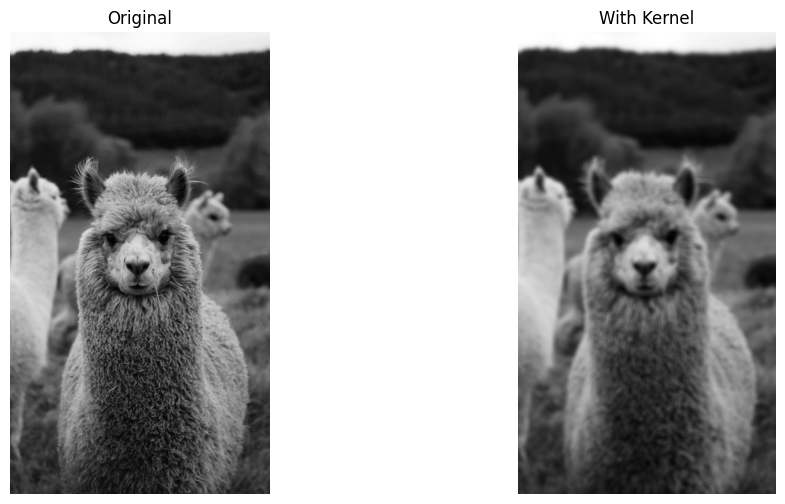

In [7]:
# Task 2: More on Convolution
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('images/llama_bw.jpg', cv2.IMREAD_GRAYSCALE)

# YOUR CODE HERE
def conv_image(img, kernel):
    """
    Apply a convolution with the kernel K onto the image patch.
    """
    h, w = img.shape
    kh, kw = kernel.shape
    output_shape = (h - kh + 1, w - kw + 1)
    output = np.zeros(output_shape, dtype = np.float32)
    # YOUR CODE HERE
    for y in range(output_shape[0]):
        for x in range(output_shape[1]):
            patch = img[y:y+kh, x:x+kw]
            output[y, x] = np.sum(patch * kernel)
    return output

def blur_image(img):
    kernel = np.ones((10,10), dtype=np.float32) / 100
    return conv_image(img, kernel)

blurred = blur_image(img)
blurred = np.clip(blurred, 0, 255).astype(np.uint8)
# Show the result
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.title("With Kernel")
plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.show()


### Handling Edges in Convolution

We are going to look at two ways of handling edges in convolution. 

1. **Method 1**: Treating all 'outside' pixels as black. This means that when you have a kernel that goes outside of the image, the pixels that the kernel tries to access that are not in the image are treated as black pixels (value 0).
2. **Method 2**: Extending pixels off the image. We can think of this as the edges of the image extending infinitely off the image as shown in the image below.

<img src="lesson_files/extend_graphic.svg" alt="Extending behavior" width="400"/>

**Your next task:** Copy your code from Task 2 (llama convolution) and code the two methods mentioned. 


In [8]:
# YOUR CODE HERE

def conv_image(img, kernel, edge_behavior='black'):
    """
    Apply a convolution with the kernel K onto the image patch.
    Handles two edge cases: outside pixels are black, and outside pixels are extended.
    """
    if edge_behavior not in ['black', 'extend']:
        raise ValueError("Invalid edge behavior. Must be 'black' or 'extend'.")
    # YOUR CODE HERE
    img = img.astype(np.float32)
    h, w = img.shape
    kh, kw = kernel.shape
    output_shape = (h, w)
    output = np.zeroes(output_shape, dtype=np.float32)
    if edge_behavior == "black":
        img = np.pad(img,
                     ((kh//2, kh//2), (kw//2, kw//2)),
                     mode="constant",
                     constant_values = 0)
        if edge_behavior == "extend" :
            img = np.pad(img,
                         ((kh//2, kh//2), (kw//2, kw//2)),
                         mode="edge")
            
    
    for y in range(output_shape[0]):
        for x in range(output_shape[1]):
            patch = img[y:y+kh, x:x+kw]
            output[y, x] = np.sum(patch * kernel)
    return output


### More fun with kernels

Using your `conv_image` function from above, we're going to learn how to **sharpen** an image. To sharpen an image, we **subtract** away a blurred version of the image. Let $I$ equal our original image. Let $B$ be our blurred image. We achieve our sharpened image $S$ using the following equation:

$$
S = 2I - B
$$

This means that we **double** our original image and subtract our blurred image once. Try this below!

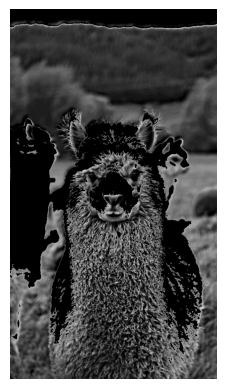

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('images/llama_bw.jpg', cv2.IMREAD_GRAYSCALE)

def conv_image(img, kernel):
    """
    Apply a valid convolution (no padding).
    """
    h, w = img.shape
    kh, kw = kernel.shape
    output_shape = (h - kh + 1, w - kw + 1)
    output = np.zeros(output_shape, dtype=np.float32)

    for y in range(output_shape[0]):
        for x in range(output_shape[1]):
            patch = img[y:y+kh, x:x+kw]
            output[y, x] = np.sum(patch * kernel)

    return output

def sharpen_image(img):
    """
    Sharpen an image using the formula S = 2I - B
    """
    # Blur kernel
    blur_kernel = np.ones((10, 10), dtype=np.float32) / 100

    # Blurred image
    blurred = conv_image(img, blur_kernel)

    # FIX: crop original image to match blurred size
    cropped_img = img[:blurred.shape[0], :blurred.shape[1]]

    # Sharpening formula
    sharpened = 2 * cropped_img - blurred

    # FIX: clip values and convert to uint8
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened

# Display the sharpened image
plt.imshow(sharpen_image(img), cmap='gray')
plt.axis('off')
plt.show()


### Challenge: Convolution on Colored Images

To perform convolution on a color image, you need to apply the convolution operation separately on each color channel (for example, Red, Green, and Blue channels in an RGB image). 

This means that you would:
 1. Split the color image into its individual channels.
 2. Apply your convolution function to each channel independently.
 3. Merge the resulting convolved channels back together to form the final output image.


[ WARN:0@4443.260] global loadsave.cpp:275 findDecoder imread_('images/llama_color.jpg'): can't open/read file: check file path/integrity


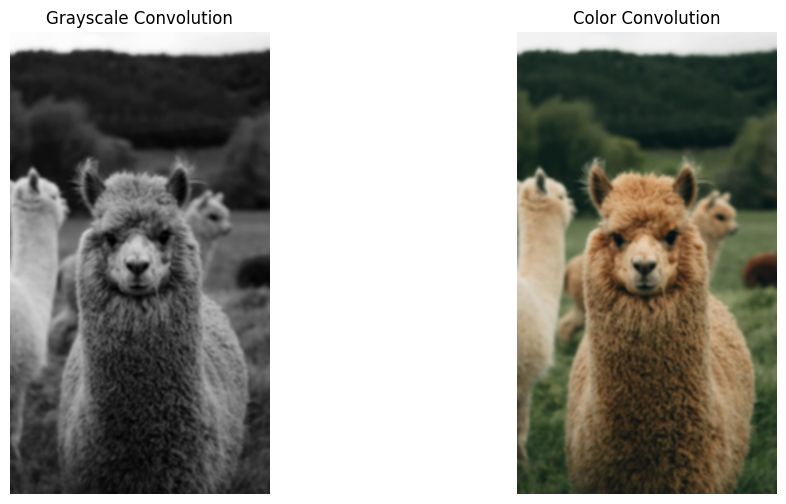

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---------- Convolution function (UNCHANGED) ----------
def conv_image(img, kernel, edge_behavior='black'):
    if edge_behavior not in ['black', 'extend']:
        raise ValueError("Invalid edge behavior. Must be 'black' or 'extend'.")

    img = img.astype(np.float32)
    kernel = kernel.astype(np.float32)

    kh, kw = kernel.shape

    def conv_single_channel(channel):
        h, w = channel.shape

        if edge_behavior == 'black':
            padded = np.pad(
                channel,
                ((kh//2, kh//2), (kw//2, kw//2)),
                mode='constant',
                constant_values=0
            )
        else:
            padded = np.pad(
                channel,
                ((kh//2, kh//2), (kw//2, kw//2)),
                mode='edge'
            )

        output = np.zeros((h, w), dtype=np.float32)

        for y in range(h):
            for x in range(w):
                patch = padded[y:y+kh, x:x+kw]
                output[y, x] = np.sum(patch * kernel)

        return output

    if img.ndim == 2:
        return conv_single_channel(img)

    elif img.ndim == 3:
        channels = []
        for c in reversed(range(img.shape[2])):
            channels.append(conv_single_channel(img[:, :, c]))
        return np.stack(channels, axis=2)

    else:
        raise ValueError("Unsupported image shape")


# ---------- Load color image ----------
img_color = cv2.imread("images/llama_color.jpg")
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ---------- Convert to grayscale ----------
img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

# ---------- Kernel ----------
kernel = np.ones((7, 7), dtype=np.float32) / 49

# ---------- Apply convolution ----------
gray_conv = conv_image(img_gray, kernel, edge_behavior='extend')
color_conv = conv_image(img_color, kernel, edge_behavior='extend')

# ---------- Prepare for display ----------
gray_conv = np.clip(gray_conv, 0, 255).astype(np.uint8)
color_conv = np.clip(color_conv, 0, 255).astype(np.uint8)

# ---------- Show results ----------
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Grayscale Convolution")
plt.imshow(gray_conv, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Color Convolution")
plt.imshow(color_conv)
plt.axis("off")

plt.show()
